In [1]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

In [2]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        if not os.path.isfile(filepath):
            utils.download_url(URL + filename, dataset_location, filename, None)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [3]:
train_loader, valid_loader, test_loader = get_data_loader("binarized_mnist", 64)

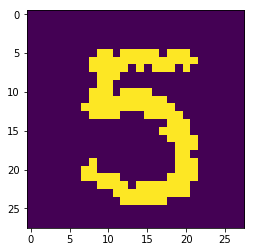

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in train_loader:
    plt.imshow(x[0, 0])
    break

In [40]:
import vae  # needed to allow the reload
import importlib
importlib.reload(vae)  # forces a reloading of the module (because jupyter notebook will not reload it after it has been modified)
from vae import VAE
from torch import optim

device = torch.device("cuda")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)


def loss_function(recon_x, x, mu, logvar):
    # ELBO: L(θ, φ; x) = -E_z~q_φ[log p_θ(x|z)] + D_KL(q_φ(z|x)||p(z))
    # reconstruction loss + regularizer (forcing the encoder's output to stay close to a standard Normal distribution)

    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train_vae(epoch, train_loader):
    model.train()
    train_loss = 0
    # for batch_idx, (data, _) in enumerate(train_loader):
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

    
def test_vae(epoch, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(20):
    train_vae(epoch, train_loader)

Train Epoch: 0 [0/50000 (0%)]	Loss: 559.434448
Train Epoch: 0 [640/50000 (1%)]	Loss: 508.527374
Train Epoch: 0 [1280/50000 (3%)]	Loss: 398.799255
Train Epoch: 0 [1920/50000 (4%)]	Loss: 371.047791
Train Epoch: 0 [2560/50000 (5%)]	Loss: 321.389526
Train Epoch: 0 [3200/50000 (6%)]	Loss: 280.178375
Train Epoch: 0 [3840/50000 (8%)]	Loss: 251.604797
Train Epoch: 0 [4480/50000 (9%)]	Loss: 230.729111
Train Epoch: 0 [5120/50000 (10%)]	Loss: 224.704010
Train Epoch: 0 [5760/50000 (12%)]	Loss: 214.979050
Train Epoch: 0 [6400/50000 (13%)]	Loss: 213.663879
Train Epoch: 0 [7040/50000 (14%)]	Loss: 207.589935
Train Epoch: 0 [7680/50000 (15%)]	Loss: 194.134140
Train Epoch: 0 [8320/50000 (17%)]	Loss: 201.056076
Train Epoch: 0 [8960/50000 (18%)]	Loss: 199.057755
Train Epoch: 0 [9600/50000 (19%)]	Loss: 201.255661
Train Epoch: 0 [10240/50000 (20%)]	Loss: 204.563583
Train Epoch: 0 [10880/50000 (22%)]	Loss: 195.626221
Train Epoch: 0 [11520/50000 (23%)]	Loss: 185.445801
Train Epoch: 0 [12160/50000 (24%)]	Loss:

C:\Users\Raphael\Miniconda3\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([16, 784])) that is different to the input size (torch.Size([16, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 1 [640/50000 (1%)]	Loss: 145.726807
Train Epoch: 1 [1280/50000 (3%)]	Loss: 140.411819
Train Epoch: 1 [1920/50000 (4%)]	Loss: 128.488907
Train Epoch: 1 [2560/50000 (5%)]	Loss: 135.772278
Train Epoch: 1 [3200/50000 (6%)]	Loss: 141.582932
Train Epoch: 1 [3840/50000 (8%)]	Loss: 136.952225
Train Epoch: 1 [4480/50000 (9%)]	Loss: 139.585571
Train Epoch: 1 [5120/50000 (10%)]	Loss: 134.790436
Train Epoch: 1 [5760/50000 (12%)]	Loss: 135.232147
Train Epoch: 1 [6400/50000 (13%)]	Loss: 139.159958
Train Epoch: 1 [7040/50000 (14%)]	Loss: 138.986389
Train Epoch: 1 [7680/50000 (15%)]	Loss: 136.350006
Train Epoch: 1 [8320/50000 (17%)]	Loss: 131.318466
Train Epoch: 1 [8960/50000 (18%)]	Loss: 131.559738
Train Epoch: 1 [9600/50000 (19%)]	Loss: 131.898743
Train Epoch: 1 [10240/50000 (20%)]	Loss: 133.782898
Train Epoch: 1 [10880/50000 (22%)]	Loss: 130.530609
Train Epoch: 1 [11520/50000 (23%)]	Loss: 134.036987
Train Epoch: 1 [12160/50000 (24%)]	Loss: 128.453674
Train Epoch: 1 [12800/50000 (26%)]	

Train Epoch: 3 [640/50000 (1%)]	Loss: 106.514832
Train Epoch: 3 [1280/50000 (3%)]	Loss: 115.956268
Train Epoch: 3 [1920/50000 (4%)]	Loss: 108.481026
Train Epoch: 3 [2560/50000 (5%)]	Loss: 103.077972
Train Epoch: 3 [3200/50000 (6%)]	Loss: 109.469719
Train Epoch: 3 [3840/50000 (8%)]	Loss: 105.841202
Train Epoch: 3 [4480/50000 (9%)]	Loss: 110.401886
Train Epoch: 3 [5120/50000 (10%)]	Loss: 102.599632
Train Epoch: 3 [5760/50000 (12%)]	Loss: 111.020531
Train Epoch: 3 [6400/50000 (13%)]	Loss: 109.728020
Train Epoch: 3 [7040/50000 (14%)]	Loss: 110.761459
Train Epoch: 3 [7680/50000 (15%)]	Loss: 106.897430
Train Epoch: 3 [8320/50000 (17%)]	Loss: 102.509895
Train Epoch: 3 [8960/50000 (18%)]	Loss: 109.090591
Train Epoch: 3 [9600/50000 (19%)]	Loss: 117.557655
Train Epoch: 3 [10240/50000 (20%)]	Loss: 104.690552
Train Epoch: 3 [10880/50000 (22%)]	Loss: 110.728661
Train Epoch: 3 [11520/50000 (23%)]	Loss: 106.563171
Train Epoch: 3 [12160/50000 (24%)]	Loss: 106.082932
Train Epoch: 3 [12800/50000 (26%)]	

Train Epoch: 5 [640/50000 (1%)]	Loss: 100.106125
Train Epoch: 5 [1280/50000 (3%)]	Loss: 102.079475
Train Epoch: 5 [1920/50000 (4%)]	Loss: 100.530128
Train Epoch: 5 [2560/50000 (5%)]	Loss: 100.938896
Train Epoch: 5 [3200/50000 (6%)]	Loss: 112.991562
Train Epoch: 5 [3840/50000 (8%)]	Loss: 102.288094
Train Epoch: 5 [4480/50000 (9%)]	Loss: 95.757401
Train Epoch: 5 [5120/50000 (10%)]	Loss: 102.021820
Train Epoch: 5 [5760/50000 (12%)]	Loss: 103.923370
Train Epoch: 5 [6400/50000 (13%)]	Loss: 100.506889
Train Epoch: 5 [7040/50000 (14%)]	Loss: 104.086754
Train Epoch: 5 [7680/50000 (15%)]	Loss: 100.122795
Train Epoch: 5 [8320/50000 (17%)]	Loss: 97.753586
Train Epoch: 5 [8960/50000 (18%)]	Loss: 103.656830
Train Epoch: 5 [9600/50000 (19%)]	Loss: 104.662933
Train Epoch: 5 [10240/50000 (20%)]	Loss: 102.263565
Train Epoch: 5 [10880/50000 (22%)]	Loss: 100.815857
Train Epoch: 5 [11520/50000 (23%)]	Loss: 99.858749
Train Epoch: 5 [12160/50000 (24%)]	Loss: 106.833488
Train Epoch: 5 [12800/50000 (26%)]	Los

Train Epoch: 7 [1280/50000 (3%)]	Loss: 106.877869
Train Epoch: 7 [1920/50000 (4%)]	Loss: 100.216469
Train Epoch: 7 [2560/50000 (5%)]	Loss: 96.693054
Train Epoch: 7 [3200/50000 (6%)]	Loss: 97.057747
Train Epoch: 7 [3840/50000 (8%)]	Loss: 97.973465
Train Epoch: 7 [4480/50000 (9%)]	Loss: 105.769653
Train Epoch: 7 [5120/50000 (10%)]	Loss: 102.813362
Train Epoch: 7 [5760/50000 (12%)]	Loss: 98.613365
Train Epoch: 7 [6400/50000 (13%)]	Loss: 95.740273
Train Epoch: 7 [7040/50000 (14%)]	Loss: 103.256516
Train Epoch: 7 [7680/50000 (15%)]	Loss: 99.303970
Train Epoch: 7 [8320/50000 (17%)]	Loss: 99.672310
Train Epoch: 7 [8960/50000 (18%)]	Loss: 101.108894
Train Epoch: 7 [9600/50000 (19%)]	Loss: 96.866425
Train Epoch: 7 [10240/50000 (20%)]	Loss: 95.272057
Train Epoch: 7 [10880/50000 (22%)]	Loss: 99.493668
Train Epoch: 7 [11520/50000 (23%)]	Loss: 102.585831
Train Epoch: 7 [12160/50000 (24%)]	Loss: 97.474197
Train Epoch: 7 [12800/50000 (26%)]	Loss: 96.054863
Train Epoch: 7 [13440/50000 (27%)]	Loss: 101